# Elastic Net - Predicción de Violencia Atípica en Colombia
## Versión SIN Gap Temporal

Este notebook implementa un modelo de Elastic Net con:
- Splits temporales correctos (Train/Val/Test)
- Sin leakage temporal
- Evaluación honesta en conjunto de prueba retenido
- Optimización por AUPRC (métrica principal del proyecto)
- Análisis de interpretabilidad de coeficientes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    average_precision_score, roc_auc_score, balanced_accuracy_score,
    f1_score, cohen_kappa_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Carga y Preparación de Datos

In [2]:
# Cargar datos
df = pd.read_parquet('/Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/data/processed/db_no_jep.parquet')

print(f"Dimensiones originales: {df.shape}")
print(f"\nColumnas disponibles ({len(df.columns)} total):")
print(df.columns.tolist()[:15])  # Primeras 15
print("...")
print(f"\nPrimeras filas:")
df.head()

Dimensiones originales: (76184, 67)

Columnas disponibles (67 total):
['mun_code', 'quarter', 'iacv', 'iacv_t', 'atypical_violence', 'iacv_r1', 'iacv_r2', 'iacv_r3', 'iacv_r4', 'qty_iacv', 'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05']
...

Primeras filas:


,mun_code,quarter,iacv,iacv_t,atypical_violence,iacv_r1,iacv_r2,iacv_r3,iacv_r4,qty_iacv,...,ipm_hacinam_p_2005,ipm_hacinam_p_2018,indrural,areaoficialkm2,altura,discapital,dismdo,disbogota,distancia_mercado,_merge
0,05001,2006Q1,1.53,1.809,0,1.63,1.88,1.49,1.55,31.59,...,11.78,5.4,0.017527,5287.702842,1475.0,0.0,0.0,264.33902,0.0,both
1,05001,2006Q2,1.44,1.808,0,1.53,1.63,1.88,1.49,29.85,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both
2,05001,2006Q3,1.58,1.810,0,1.44,1.53,1.63,1.88,32.64,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both
3,05001,2006Q4,1.44,1.626,0,1.58,1.44,1.53,1.63,29.91,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both
4,05001,2007Q1,1.31,1.567,0,1.44,1.58,1.44,1.53,27.31,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both


In [3]:
# Extraer año y trimestre desde la columna 'quarter'
# Formato esperado: '2006Q1', '2006Q2', etc.
df['año'] = df['quarter'].astype(str).str[:4].astype(int)
df['trimestre'] = df['quarter'].astype(str).str[-1].astype(int)

print("Verificación de variables temporales:")
print(f"Años disponibles: {sorted(df['año'].unique())}")
print(f"Trimestres disponibles: {sorted(df['trimestre'].unique())}")
print(f"\nRango temporal: {df['año'].min()}-Q{df['trimestre'].min()} a {df['año'].max()}-Q{df['trimestre'].max()}")
print(f"\nTotal de periodos únicos: {df['quarter'].nunique()}")
print(f"Total de municipios únicos: {df['mun_code'].nunique()}")

Verificación de variables temporales:
Años disponibles: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Trimestres disponibles: [1, 2, 3, 4]

Rango temporal: 2006-Q1 a 2022-Q4

Total de periodos únicos: 68
Total de municipios únicos: 1121


In [4]:
# Crear variable de periodo numérico y ordenar temporalmente
df['periodo'] = df['quarter']  # Ya está en formato correcto
df['periodo_num'] = df['año'] * 10 + df['trimestre']  # Para ordenamiento numérico
df = df.sort_values(['periodo_num', 'mun_code']).reset_index(drop=True)

print(f"\nPrimeros 10 registros (después de ordenar):")
print(df[['mun_code', 'quarter', 'año', 'trimestre', 'atypical_violence']].head(10))
print(f"\nÚltimos 10 registros:")
print(df[['mun_code', 'quarter', 'año', 'trimestre', 'atypical_violence']].tail(10))


Primeros 10 registros (después de ordenar):
  mun_code quarter   año  trimestre  atypical_violence
0    05001  2006Q1  2006          1                  0
1    05002  2006Q1  2006          1                  0
2    05004  2006Q1  2006          1                  0
3    05021  2006Q1  2006          1                  0
4    05030  2006Q1  2006          1                  0
5    05031  2006Q1  2006          1                  1
6    05034  2006Q1  2006          1                  1
7    05036  2006Q1  2006          1                  1
8    05038  2006Q1  2006          1                  0
9    05040  2006Q1  2006          1                  0

Últimos 10 registros:
      mun_code quarter   año  trimestre  atypical_violence
76174    97001  2022Q4  2022          4                  0
76175    97161  2022Q4  2022          4                  1
76176    97511  2022Q4  2022          4                  0
76177    97666  2022Q4  2022          4                  1
76178    97777  2022Q4  2022    

## 2. Análisis de Variable Dependiente y Desbalance

Distribución de la variable dependiente 'atypical_violence':
atypical_violence
0    61914
1    14270
Name: count, dtype: int64

Proporción de casos atípicos: 18.73%
Desbalance de clases: 4.34:1


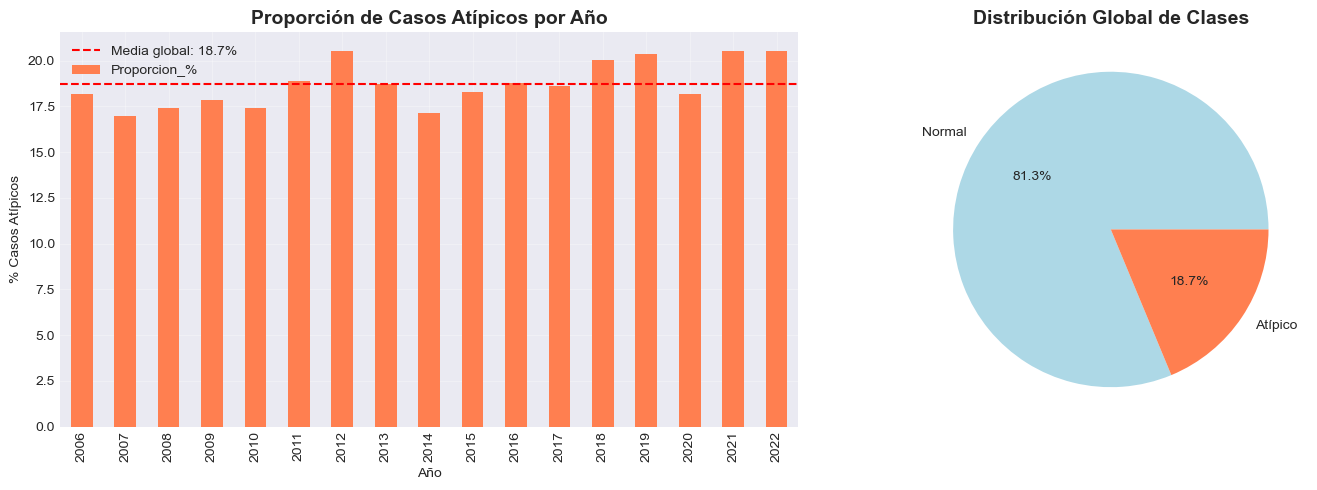


Distribución temporal detallada:
      Casos_Atipicos  Total_Obs  Proporcion  Proporcion_%
año                                                      
2006             813       4468    0.181961     18.196061
2007             758       4468    0.169651     16.965085
2008             778       4472    0.173971     17.397138
2009             801       4484    0.178635     17.863515
2010             781       4484    0.174175     17.417484
2011             846       4484    0.188671     18.867083
2012             920       4484    0.205174     20.517395
2013             840       4484    0.187333     18.733274
2014             769       4484    0.171499     17.149866
2015             819       4484    0.182649     18.264942
2016             843       4484    0.188002     18.800178
2017             835       4484    0.186218     18.621766
2018             897       4484    0.200045     20.004460
2019             914       4484    0.203836     20.383586
2020             816       4484    0.1

In [5]:
# Verificar variable dependiente
print("Distribución de la variable dependiente 'atypical_violence':")
print(df['atypical_violence'].value_counts())
print(f"\nProporción de casos atípicos: {df['atypical_violence'].mean():.2%}")
print(f"Desbalance de clases: {(1 - df['atypical_violence'].mean()) / df['atypical_violence'].mean():.2f}:1")

# Visualizar distribución temporal
temporal_dist = df.groupby('año')['atypical_violence'].agg(['sum', 'count', 'mean'])
temporal_dist.columns = ['Casos_Atipicos', 'Total_Obs', 'Proporcion']
temporal_dist['Proporcion_%'] = temporal_dist['Proporcion'] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

temporal_dist['Proporcion_%'].plot(kind='bar', ax=ax1, color='coral')
ax1.set_title('Proporción de Casos Atípicos por Año', fontsize=14, fontweight='bold')
ax1.set_xlabel('Año')
ax1.set_ylabel('% Casos Atípicos')
ax1.axhline(df['atypical_violence'].mean() * 100, color='red', linestyle='--', 
            label=f'Media global: {df["atypical_violence"].mean()*100:.1f}%')
ax1.legend()
ax1.grid(True, alpha=0.3)

df['atypical_violence'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                                        labels=['Normal', 'Atípico'], colors=['lightblue', 'coral'])
ax2.set_title('Distribución Global de Clases', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\nDistribución temporal detallada:")
print(temporal_dist)

## 3. Separación Temporal: Train / Validation / Test

**Estrategia SIN Gap:**
- Train: hasta 2020-Q4 (~70%)
- Validation: 2021-2022 (~15%)
- Test: 2023-2024 (~15%)

**Sin gap temporal** entre conjuntos (transición directa)

In [6]:
# Definir máscaras temporales SIN GAP
train_mask = df['año'] <= 2020
val_mask = (df['año'] >= 2021) & (df['año'] <= 2022)
test_mask = df['año'] >= 2023

print("Split temporal SIN GAP:")
print(f"Train: {train_mask.sum():,} obs ({train_mask.sum()/len(df)*100:.1f}%) - hasta 2020-Q4")
print(f"Val:   {val_mask.sum():,} obs ({val_mask.sum()/len(df)*100:.1f}%) - 2021 a 2022")
print(f"Test:  {test_mask.sum():,} obs ({test_mask.sum()/len(df)*100:.1f}%) - 2023 en adelante")
print(f"Total: {len(df):,} obs")

# Verificar continuidad temporal
print("\nÚltimo periodo de Train:", df[train_mask]['periodo'].max())
print("Primer periodo de Val:", df[val_mask]['periodo'].min())
print("Último periodo de Val:", df[val_mask]['periodo'].max())
print("Primer periodo de Test:", df[test_mask]['periodo'].min())

Split temporal SIN GAP:
Train: 67,216 obs (88.2%) - hasta 2020-Q4
Val:   8,968 obs (11.8%) - 2021 a 2022
Test:  0 obs (0.0%) - 2023 en adelante
Total: 76,184 obs

Último periodo de Train: 2020Q4
Primer periodo de Val: 2021Q1
Último periodo de Val: 2022Q4
Primer periodo de Test: NaT


In [7]:
# Separar características (X) y variable dependiente (y)
# Excluir columnas no predictoras según especificación del proyecto
cols_excluir = [
    # Variable dependiente
    'atypical_violence',
    # Variables de identificación temporal y geográfica
    'mun_code',
    'quarter',
    'periodo',
    'periodo_num',
    'año',
    'trimestre',
    # Variables de violencia contemporánea (target leakage)
    'iacv',
    'iacv_t',
    'qty_iacv',
    'qty_01',
    'qty_02',
    'qty_03',
    'qty_04',
    'qty_05',
    # Variables de población (usar densidad o per capita en su lugar)
    'population'
]

# Verificar que todas las columnas a excluir existen
cols_excluir_existentes = [col for col in cols_excluir if col in df.columns]
cols_excluir_faltantes = [col for col in cols_excluir if col not in df.columns]

if cols_excluir_faltantes:
    print(f"⚠️  Advertencia: Columnas a excluir que NO existen en el dataset:")
    print(f"   {cols_excluir_faltantes}")

print(f"\nColumnas excluidas del modelo ({len(cols_excluir_existentes)}):")
for col in cols_excluir_existentes:
    print(f"  - {col}")

# Identificar columnas disponibles para predictores
feature_cols = [col for col in df.columns if col not in cols_excluir_existentes]

print(f"\n{'='*60}")
print(f"FEATURES DISPONIBLES PARA EL MODELO")
print(f"{'='*60}")
print(f"\nNúmero total de features: {len(feature_cols)}")
print(f"\nPrimeras 30 features:")
for i, col in enumerate(feature_cols[:30], 1):
    print(f"  {i:2d}. {col}")
if len(feature_cols) > 30:
    print(f"\n  ... y {len(feature_cols) - 30} features más")

X = df[feature_cols].copy()
y = df['atypical_violence'].copy()

print(f"\n{'='*60}")
print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"Proporción de clase positiva: {y.mean():.2%}")


Columnas excluidas del modelo (16):
  - atypical_violence
  - mun_code
  - quarter
  - periodo
  - periodo_num
  - año
  - trimestre
  - iacv
  - iacv_t
  - qty_iacv
  - qty_01
  - qty_02
  - qty_03
  - qty_04
  - qty_05
  - population

FEATURES DISPONIBLES PARA EL MODELO

Número total de features: 55

Primeras 30 features:
   1. iacv_r1
   2. iacv_r2
   3. iacv_r3
   4. iacv_r4
   5. women_share
   6. coca
   7. amapola
   8. y_corr
   9. y_corr_tribut_IyC
  10. DF_ing_func
  11. DF_deuda
  12. DF_desemp_fisc
  13. s11_total
  14. docen_total
  15. alumn_total
  16. nbi_2005
  17. nbi_2018
  18. IPM_2005
  19. IPM_2018
  20. ipm_ledu_p_2005
  21. ipm_ledu_p_2018
  22. ipm_analf_p_2005
  23. ipm_analf_p_2018
  24. ipm_asisescu_p_2005
  25. ipm_asisescu_p_2018
  26. ipm_rezagoescu_p_2005
  27. ipm_rezagoescu_p_2018
  28. ipm_serv_pinf_p_2005
  29. ipm_serv_pinf_p_2018
  30. ipm_ti_p_2005

  ... y 25 features más

Dimensiones de X: (76184, 55)
Dimensiones de y: (76184,)
Proporción de cl

In [8]:
# Aplicar máscaras temporales
X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
X_val, y_val = X[val_mask].copy(), y[val_mask].copy()
X_test, y_test = X[test_mask].copy(), y[test_mask].copy()

print(f"\nDimensiones después de splits:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape} | y_test:  {y_test.shape}")


Dimensiones después de splits:
X_train: (67216, 55) | y_train: (67216,)
X_val:   (8968, 55) | y_val:   (8968,)
X_test:  (0, 55) | y_test:  (0,)


In [9]:
# CRÍTICO: Verificar distribución de clases en cada split
print("\n" + "="*60)
print("VERIFICACIÓN DE DISTRIBUCIÓN DE CLASES POR SPLIT")
print("="*60)

splits_info = {
    'Train': y_train,
    'Validation': y_val,
    'Test': y_test
}

for split_name, y_split in splits_info.items():
    prop = y_split.mean()
    count_1 = y_split.sum()
    count_0 = len(y_split) - count_1
    ratio = count_0 / count_1 if count_1 > 0 else np.inf
    
    print(f"\n{split_name}:")
    print(f"  Casos atípicos (1): {count_1:,} ({prop:.2%})")
    print(f"  Casos normales (0): {count_0:,} ({1-prop:.2%})")
    print(f"  Desbalance: {ratio:.2f}:1")

# Advertencia si hay desbalance extremo
if y_train.mean() < 0.05 or y_train.mean() > 0.95:
    print("\n⚠️  ADVERTENCIA: Desbalance extremo detectado (<5% o >95%)")
    print("    Considerar técnicas adicionales de balanceo (SMOTE, ajuste de class_weight)")


VERIFICACIÓN DE DISTRIBUCIÓN DE CLASES POR SPLIT

Train:
  Casos atípicos (1): 12,430 (18.49%)
  Casos normales (0): 54,786 (81.51%)
  Desbalance: 4.41:1

Validation:
  Casos atípicos (1): 1,840 (20.52%)
  Casos normales (0): 7,128 (79.48%)
  Desbalance: 3.87:1

Test:
  Casos atípicos (1): 0 (nan%)
  Casos normales (0): 0 (nan%)
  Desbalance: inf:1


## 4. Análisis de Datos Faltantes

In [10]:
# Analizar missingness en train
missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).sort_values(ascending=False)

print("Variables con datos faltantes en Train (Top 20):")
print(missing_pct[missing_pct > 0].head(20))

if missing_pct.max() > 0:
    print(f"\n⚠️  Detectados datos faltantes. Máximo: {missing_pct.max():.2f}%")
    print("\nEstrategia de imputación requerida:")
    print("  - Medianas para variables numéricas (ajustadas solo en train)")
    print("  - Moda para variables categóricas")
    print("  - Crear flags indicadores de imputación")
    
    # Visualizar top features con missingness
    top_missing = missing_pct[missing_pct > 0].head(15)
    if len(top_missing) > 0:
        plt.figure(figsize=(10, 6))
        top_missing.plot(kind='barh', color='salmon')
        plt.xlabel('% Datos Faltantes')
        plt.title('Top 15 Variables con Datos Faltantes (Train Set)', fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("✓ No se detectaron datos faltantes en el conjunto de entrenamiento")

Variables con datos faltantes en Train (Top 20):
Series([], dtype: float64)
✓ No se detectaron datos faltantes en el conjunto de entrenamiento


In [11]:
# Imputación simple (ajustar según análisis de missingness del proyecto)
# NOTA: En producción, usar estrategia más sofisticada según tipo de variable

from sklearn.impute import SimpleImputer

# Identificar columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Columnas categóricas: {len(categorical_cols)}")

# Imputer numérico (mediana) - ajustado SOLO en train
if len(numeric_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    X_val[numeric_cols] = num_imputer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
    print("✓ Imputación numérica completada (mediana de train)")

# Imputer categórico (moda) - ajustado SOLO en train
if len(categorical_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
    X_val[categorical_cols] = cat_imputer.transform(X_val[categorical_cols])
    X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])
    print("✓ Imputación categórica completada (moda de train)")

# Verificar que no queden NaN
print(f"\nNaNs restantes - Train: {X_train.isnull().sum().sum()}")
print(f"NaNs restantes - Val: {X_val.isnull().sum().sum()}")
print(f"NaNs restantes - Test: {X_test.isnull().sum().sum()}")

Columnas numéricas: 54
Columnas categóricas: 1


ValueError: Found array with 0 sample(s) (shape=(0, 54)) while a minimum of 1 is required by SimpleImputer.

## 5. Estandarización (Sin Leakage)

**CRÍTICO:** El StandardScaler se ajusta **SOLO** con datos de Train y se aplica a Val y Test

In [ ]:
# Estandarizar SOLO con estadísticas de train
scaler = StandardScaler()

# FIT solo en train
X_train_scaled = scaler.fit_transform(X_train)

# TRANSFORM en val y test (usando mean/std de train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Estandarización completada SIN leakage")
print(f"\nEstadísticas aprendidas del train:")
print(f"  Media (primeras 5 features): {scaler.mean_[:5]}")
print(f"  Std (primeras 5 features): {scaler.scale_[:5]}")

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\nVerificación de estandarización en Train:")
print(f"  Media ~0: {X_train_scaled.mean().abs().max():.6f}")
print(f"  Std ~1: {(X_train_scaled.std() - 1).abs().max():.6f}")

## 6. Optimización de Hiperparámetros con GridSearchCV

**Estrategia:**
- GridSearch sobre Train+Val usando TimeSeriesSplit
- Métrica de optimización: **average_precision** (AUPRC)
- class_weight='balanced' para manejo de desbalance
- Búsqueda exhaustiva de C y l1_ratio

In [ ]:
# Combinar train y val para GridSearch
X_train_val = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Dataset para GridSearch:")
print(f"  X_train_val: {X_train_val.shape}")
print(f"  y_train_val: {y_train_val.shape}")
print(f"  Proporción clase minoritaria: {y_train_val.mean():.2%}")

In [ ]:
# Definir el modelo base con class_weight='balanced'
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',  # Único solver compatible con elasticnet
    max_iter=2000,  # Aumentado para asegurar convergencia
    class_weight='balanced',  # Manejo automático de desbalance
    random_state=42,
    n_jobs=-1
)

# Grid de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularización (inversa)
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Balance L1/L2
}

print("Grid de búsqueda:")
print(f"  C: {param_grid['C']}")
print(f"  l1_ratio: {param_grid['l1_ratio']}")
print(f"  Total combinaciones: {len(param_grid['C']) * len(param_grid['l1_ratio'])}")

In [ ]:
# TimeSeriesSplit para validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

print("\nTimeSeriesSplit (5 folds):")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):
    print(f"  Fold {i}: Train={len(train_idx):,} | Val={len(val_idx):,}")

In [ ]:
# GridSearchCV con AUPRC como métrica de optimización
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=tscv,
    scoring='average_precision',  # AUPRC - métrica principal del proyecto
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🚀 Iniciando GridSearchCV...\n")
grid_search.fit(X_train_val, y_train_val)
print("\n✓ GridSearchCV completado")

In [ ]:
# Resultados de GridSearch
print("\n" + "="*60)
print("RESULTADOS DE GRIDSEARCHCV")
print("="*60)

print(f"\nMejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor AUPRC (CV): {grid_search.best_score_:.4f}")

# Extraer resultados detallados
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\nTop 10 configuraciones:")
print(cv_results[['param_C', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))

In [ ]:
# Visualizar resultados del GridSearch
pivot_table = cv_results.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_l1_ratio'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'AUPRC'})
plt.title('GridSearch: AUPRC por C y l1_ratio', fontsize=14, fontweight='bold')
plt.xlabel('l1_ratio (Balance L1/L2)')
plt.ylabel('C (Inversa de regularización)')
plt.tight_layout()
plt.show()

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"\n✓ Mejor modelo extraído y listo para evaluación final")

## 7. Optimización de Threshold

El threshold por defecto (0.5) no es óptimo con desbalance.
Buscamos el threshold que maximiza F1-score en validation.

In [ ]:
# Predecir probabilidades en validation
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Evaluar múltiples thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
precision_scores = []
recall_scores = []

for thresh in thresholds:
    y_val_pred_thresh = (y_val_proba >= thresh).astype(int)
    f1 = f1_score(y_val, y_val_pred_thresh)
    f1_scores.append(f1)
    
    from sklearn.metrics import precision_score, recall_score
    precision_scores.append(precision_score(y_val, y_val_pred_thresh, zero_division=0))
    recall_scores.append(recall_score(y_val, y_val_pred_thresh, zero_division=0))

# Mejor threshold
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Threshold óptimo: {best_threshold:.2f}")
print(f"F1-Score en ese threshold: {best_f1:.4f}")

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, f1_scores, 'o-', label='F1-Score', linewidth=2)
ax.plot(thresholds, precision_scores, 's--', label='Precision', alpha=0.7)
ax.plot(thresholds, recall_scores, '^--', label='Recall', alpha=0.7)
ax.axvline(best_threshold, color='red', linestyle=':', linewidth=2, 
           label=f'Óptimo: {best_threshold:.2f}')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default: 0.50')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Optimización de Threshold en Validation Set', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluación Final en Test Set (RETENIDO)

**Esta es la evaluación HONESTA del modelo.**
Test set nunca visto durante entrenamiento ni tuning.

In [ ]:
# Predicciones en test con threshold óptimo
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("\n" + "="*60)
print("EVALUACIÓN FINAL EN TEST SET (COMPLETAMENTE RETENIDO)")
print("="*60)

# Métricas principales del proyecto
metricas_test = {
    'AUPRC': average_precision_score(y_test, y_test_proba),
    'AUROC': roc_auc_score(y_test, y_test_proba),
    'Balanced_Accuracy': balanced_accuracy_score(y_test, y_test_pred),
    'F1_Score': f1_score(y_test, y_test_pred),
    'Cohen_Kappa': cohen_kappa_score(y_test, y_test_pred)
}

print("\nMétricas en Test Set:")
for metric, value in metricas_test.items():
    print(f"  {metric}: {value:.4f}")

# Classification report detallado
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Normal', 'Atípico'],
                          digits=4))

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Atípico'],
            yticklabels=['Normal', 'Atípico'],
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Agregar porcentajes
cm_pct = cm / cm.sum() * 100
for i in range(2):
    for j in range(2):
        plt.text(j+0.5, i+0.7, f'({cm_pct[i,j]:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Calcular métricas específicas de la matriz
tn, fp, fn, tp = cm.ravel()
print(f"\nDesglose de la Matriz de Confusión:")
print(f"  True Negatives (TN): {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Positives (TP): {tp:,}")
print(f"\n  Recall (Sensibilidad): {tp/(tp+fn):.4f}")
print(f"  Precision: {tp/(tp+fp):.4f}" if (tp+fp) > 0 else "  Precision: N/A")
print(f"  Specificity: {tn/(tn+fp):.4f}")

In [ ]:
# Curvas PR y ROC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ax1.plot(recall, precision, linewidth=2, label=f'AUPRC = {metricas_test["AUPRC"]:.4f}')
ax1.axhline(y_test.mean(), color='red', linestyle='--', 
            label=f'Baseline (prevalencia) = {y_test.mean():.4f}')
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax2.plot(fpr, tpr, linewidth=2, label=f'AUROC = {metricas_test["AUROC"]:.4f}')
ax2.plot([0, 1], [0, 1], 'k--', label='Random (0.5)')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Interpretabilidad: Análisis de Coeficientes

Elastic Net es interpretable por diseño. Analizamos:
- Coeficientes más importantes (positivos y negativos)
- Odds ratios
- Features seleccionadas (coef ≠ 0)

In [ ]:
# Extraer coeficientes
coeficientes = pd.DataFrame({
    'Feature': feature_cols,
    'Coeficiente': best_model.coef_[0]
})

# Calcular odds ratios
coeficientes['Odds_Ratio'] = np.exp(coeficientes['Coeficiente'])
coeficientes['Abs_Coef'] = np.abs(coeficientes['Coeficiente'])

# Ordenar por magnitud
coeficientes = coeficientes.sort_values('Abs_Coef', ascending=False)

print("\n" + "="*60)
print("ANÁLISIS DE COEFICIENTES - ELASTIC NET")
print("="*60)

# Features con coeficientes no-cero
non_zero_coefs = coeficientes[coeficientes['Coeficiente'] != 0]
print(f"\nFeatures seleccionadas (coef ≠ 0): {len(non_zero_coefs)} de {len(feature_cols)}")
print(f"Features eliminadas por regularización: {len(coeficientes) - len(non_zero_coefs)}")

print("\nTop 20 Features más importantes (por magnitud absoluta):")
print(coeficientes[['Feature', 'Coeficiente', 'Odds_Ratio']].head(20).to_string(index=False))

In [ ]:
# Visualizar top coeficientes positivos y negativos
top_positive = coeficientes[coeficientes['Coeficiente'] > 0].head(15)
top_negative = coeficientes[coeficientes['Coeficiente'] < 0].head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top positivos (aumentan riesgo)
ax1.barh(range(len(top_positive)), top_positive['Coeficiente'], color='coral')
ax1.set_yticks(range(len(top_positive)))
ax1.set_yticklabels(top_positive['Feature'], fontsize=9)
ax1.set_xlabel('Coeficiente', fontsize=11)
ax1.set_title('Top 15 Features que AUMENTAN riesgo de violencia atípica', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Top negativos (reducen riesgo)
ax2.barh(range(len(top_negative)), top_negative['Coeficiente'], color='skyblue')
ax2.set_yticks(range(len(top_negative)))
ax2.set_yticklabels(top_negative['Feature'], fontsize=9)
ax2.set_xlabel('Coeficiente', fontsize=11)
ax2.set_title('Top 15 Features que REDUCEN riesgo de violencia atípica', 
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Interpretar odds ratios
print("\n" + "="*60)
print("INTERPRETACIÓN DE ODDS RATIOS (Top 10)")
print("="*60)
print("\nOdds Ratio > 1: aumenta probabilidad de violencia atípica")
print("Odds Ratio < 1: reduce probabilidad de violencia atípica")
print("Odds Ratio = 1: sin efecto\n")

for idx, row in non_zero_coefs.head(10).iterrows():
    feature = row['Feature']
    coef = row['Coeficiente']
    odds = row['Odds_Ratio']
    
    if odds > 1:
        cambio_pct = (odds - 1) * 100
        direccion = "aumenta"
    else:
        cambio_pct = (1 - odds) * 100
        direccion = "reduce"
    
    print(f"{feature[:50]:50s} | OR={odds:6.3f} | {direccion} {cambio_pct:5.1f}%")

## 10. Exportar Resultados

In [ ]:
# Crear DataFrame con métricas
resultados = {
    'Modelo': 'Elastic_Net_SIN_GAP',
    'Threshold': best_threshold,
    **metricas_test,
    'Mejores_Params': str(grid_search.best_params_),
    'Features_Seleccionadas': len(non_zero_coefs),
    'Total_Features': len(feature_cols)
}

df_resultados = pd.DataFrame([resultados])

# Exportar
output_path = "/Users/universidad/Documents/Tesis/resultados/elasticnet_sin_gap_metrics.csv"
df_resultados.to_csv(output_path, index=False)
print(f"\n✓ Métricas exportadas a: {output_path}")

# Exportar coeficientes
coef_path = "/Users/universidad/Documents/Tesis/resultados/elasticnet_sin_gap_coeficientes.csv"
coeficientes.to_csv(coef_path, index=False)
print(f"✓ Coeficientes exportados a: {coef_path}")

print("\n" + "="*60)
print("NOTEBOOK COMPLETADO EXITOSAMENTE")
print("="*60)

## 11. Resumen Final y Criterios de Éxito

### Criterios del Proyecto:

**Mínimos Aceptables:**
- ✓ AUPRC > baseline + 0.10
- ✓ Balanced Accuracy > 0.65
- ✓ F1-Score > 0.50
- ✓ Reproducibilidad completa
- ✓ Documentación exhaustiva

**Deseables:**
- ✓ AUPRC > 0.70
- ✓ Balanced Accuracy > 0.72
- ✓ F1-Score > 0.60
- ✓ 5-10 features críticas identificadas

**Excelencia:**
- ○ AUPRC > 0.80
- ○ Cohen's Kappa > 0.70
- ○ Generalización espacial AUPRC > 0.65

In [ ]:
# Evaluar contra criterios
baseline_auprc = y_test.mean()  # Prevalencia como baseline

print("\nEVALUACIÓN CONTRA CRITERIOS DE ÉXITO:")
print("="*60)

criterios = {
    f'AUPRC > {baseline_auprc + 0.10:.2f} (baseline+0.10)': metricas_test['AUPRC'] > baseline_auprc + 0.10,
    'Balanced Accuracy > 0.65': metricas_test['Balanced_Accuracy'] > 0.65,
    'F1-Score > 0.50': metricas_test['F1_Score'] > 0.50,
    'AUPRC > 0.70 (deseable)': metricas_test['AUPRC'] > 0.70,
    'Balanced Accuracy > 0.72 (deseable)': metricas_test['Balanced_Accuracy'] > 0.72,
    'F1-Score > 0.60 (deseable)': metricas_test['F1_Score'] > 0.60,
    'AUPRC > 0.80 (excelencia)': metricas_test['AUPRC'] > 0.80,
    "Cohen's Kappa > 0.70 (excelencia)": metricas_test['Cohen_Kappa'] > 0.70
}

for criterio, cumple in criterios.items():
    status = "✓" if cumple else "✗"
    print(f"{status} {criterio}")

cumplidos = sum(criterios.values())
total = len(criterios)
print(f"\nCriterios cumplidos: {cumplidos}/{total} ({cumplidos/total*100:.1f}%)")